# Comparing Logistic Regression against Pairwise Logistic Regression

We have 4 cohorts in our dataset and we want to find the KEGGs that discriminate between them. We visualize the KEGG distributions with heatmaps organized by hierarchical clustering. The dataest has 63 subjects and ~10K KEGGs.

**Part 1: Logistic Regression with Lasso Penalty**

We use Logistic Regressiong with Lasso Penalty. This is a classic model that yields sparse solutions; that is we find the sparse set of important KEGGs. We select the Lasso Penatly weight using cross validation as is typically done.  

In this case the dataset has 63 rows and ~10K columns

**Part 2: Pairwise Comparison between cohorts using Logistic Regression with Lasso Penalty**

We prepare the data by computing pairwise comparisons between the different subjects then apply binary Logistic Regression with Lasso Penalty on whether a pair of samples belong in the same group. The KEGGs that distinguish the different groups are then considered important.

In this case the dataset has *1953 rows* and ~10K columns. We posit since there are more rows the data is better regularized and will yield a sparser set compared to the set of KEGGs found in Part 1 above. 


In [1]:
import pandas as pd
import numpy as np

import itertools
from sklearn.linear_model import LogisticRegressionCV

import matplotlib.pylab as plt
import seaborn as sns;
%matplotlib inline

# Data Prep

In [2]:
df = pd.read_csv("../../data/keggs-subjects-rf-scores.csv")

df.head()

,kegg,over.abundant.health.conf,LS001,LS002,LS003,LS004,LS005,LS006,LS007,CD.SRS301865,...,HE.SRS016335,HE.SRS016495,HE.SRS017103,HE.SRS017433,HE.SRS018427,HE.SRS018656,HE.SRS020328,HE.SRS020869,HE.SRS022713,HE.SRS016585.suspect
0,K00001(alcohol_dehydrogenase),0.366,0.005732,0.006140,0.006243,0.005962,0.008011,0.004744,0.005444,0.005043,...,0.002705,0.005025,0.003359,0.004281,0.003052,0.003625,0.002673,0.003999,0.003734,8.220359e-03
1,K00002(alcohol_dehydrogenase_(NADP+)),0.312,0.000382,0.000409,0.000610,0.000533,0.000313,0.000412,0.000390,0.001005,...,0.000461,0.000255,0.000071,0.000014,0.000248,0.000649,0.000151,0.000157,0.000000,4.812945e-07
2,K00003(homoserine_dehydrogenase),0.310,0.000855,0.001034,0.001125,0.001074,0.001224,0.000721,0.000786,0.001025,...,0.000195,0.001063,0.000249,0.000131,0.000351,0.000676,0.000430,0.000318,0.000050,1.209999e-06
3,"K00004((R,R)-butanediol_dehydrogenase_/_diacet...",0.192,0.000091,0.000106,0.000149,0.000116,0.000064,0.000084,0.000080,0.000016,...,0.000006,0.000025,0.000008,0.000008,0.000014,0.000039,0.000068,0.000010,0.000006,4.127393e-04
4,K00005(glycerol_dehydrogenase),0.004,0.000167,0.000236,0.000223,0.000203,0.000218,0.000144,0.000143,0.000166,...,0.000012,0.000427,0.000030,0.000004,0.000034,0.000036,0.000055,0.000065,0.000000,2.158647e-04


In [3]:
X = df.iloc[:,2:].values
np.min(X[X>0])

3.1125837891788104e-09

In [4]:
laplace_scale = 1e-9

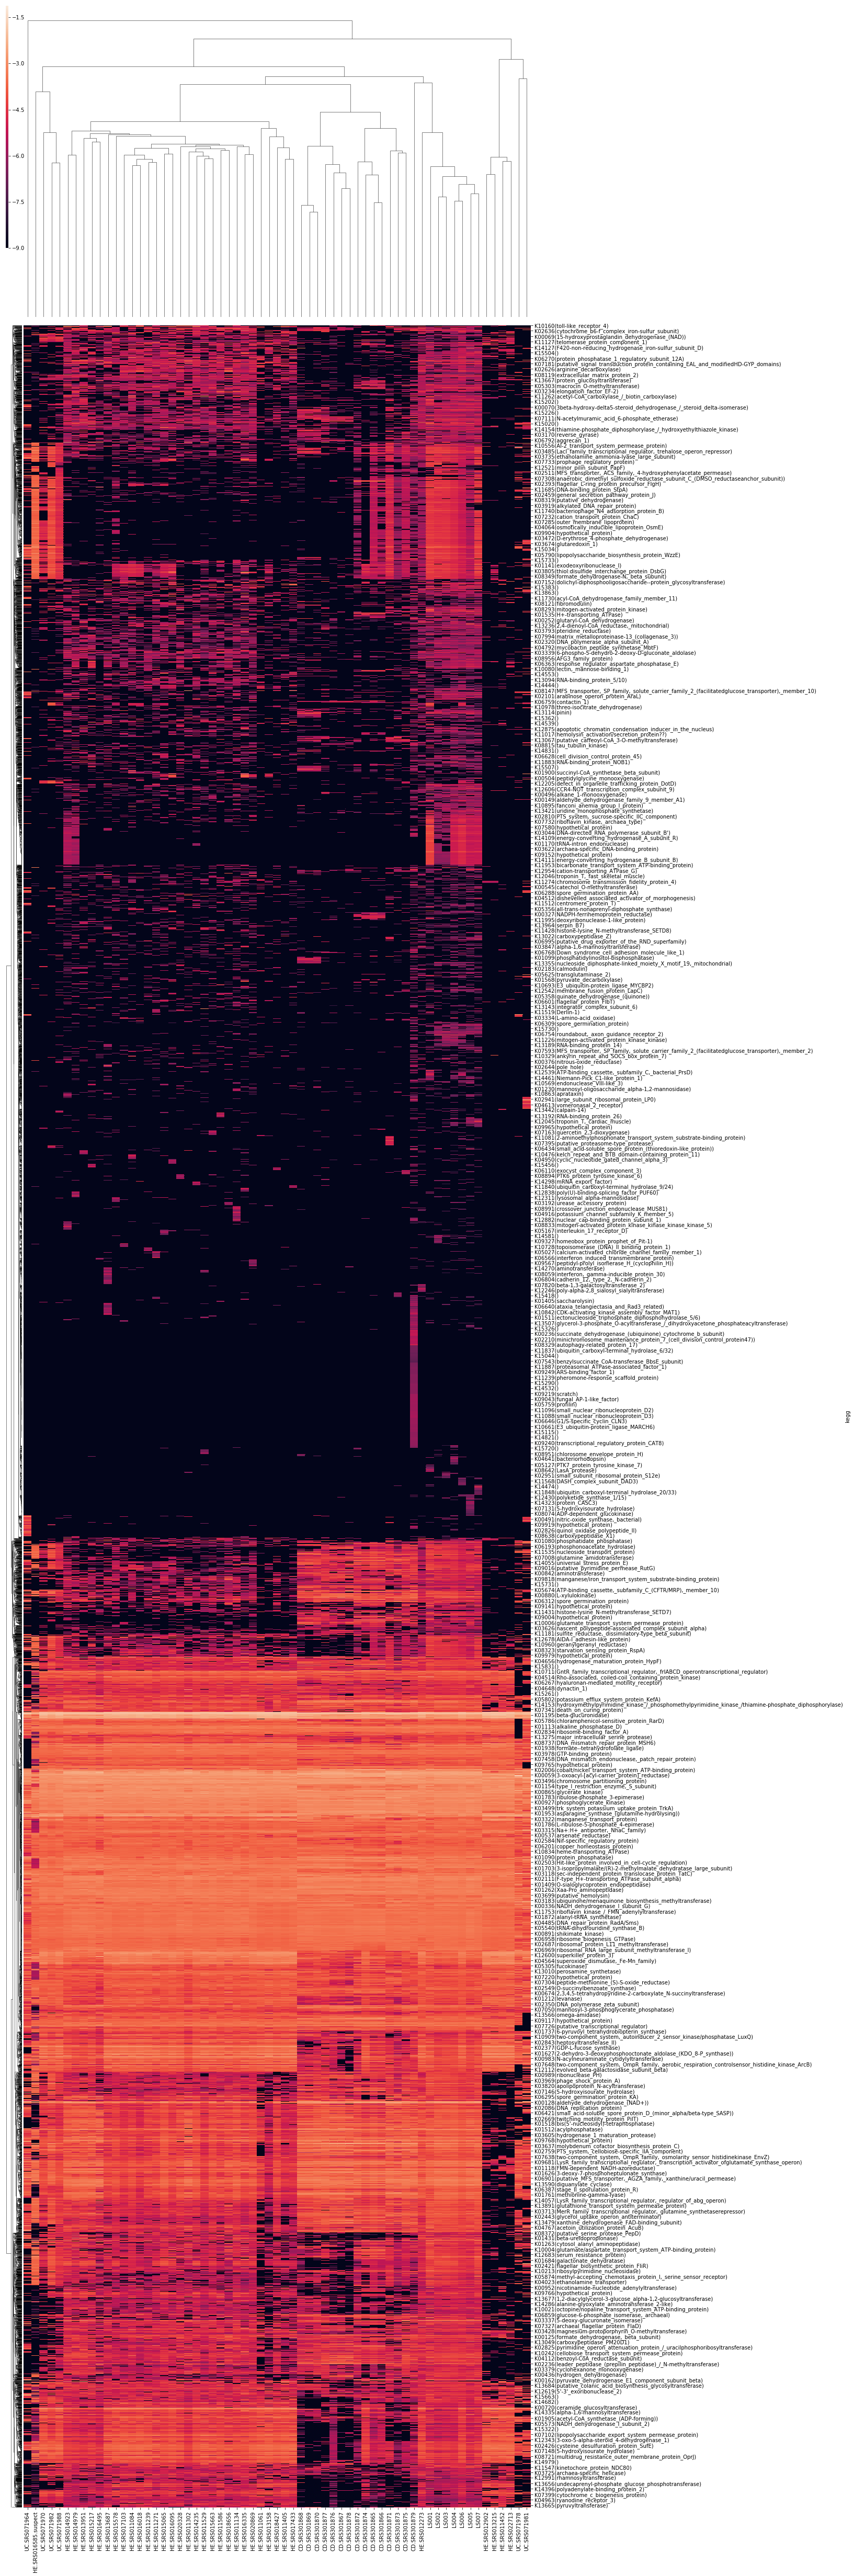

In [5]:
df.index = df.kegg

sns.clustermap(np.log10(laplace_scale+df.iloc[:,2:]),figsize=(18, 88));

Above we show the clustered heatmap of the entire dataset. There is a lot of structure in the data but a lot of KEGGs actually confuse the hierarchical clustering algorithm and hence we observe that some subjects are grouped together when they in fact they do not belong together (for example the 4 HE and 2 UC subjects in the far right). 

There are many explanations for this, one being the "curse of dimensionality" - the clustering algortihm uses euclidean distance (which is an accceptable distance metric to use on log-transformed data), however distances become harder to distnguish in higher dimensions. Hence, it is harder to distinguish different cohorts with more KEGGs.

# Part 1: Lasso Logistic Regression

We use Logistic Regression with lasso penalty to find the important KEGGs. We use Lasso since the Lasso yields sparse solutions. The weight for lasso penalty is select with cross validation. 

In [36]:
X = df.iloc[:,2:].values.T

y = np.zeros(X.shape[0]) # 0 is healthy

y[np.where(df.iloc[:, 2:].columns.str.contains("LS"))[0]] = 1 # 1 is LS
y[np.where(df.iloc[:, 2:].columns.str.contains("CD"))[0]] = 2 # 2 is CD
y[np.where(df.iloc[:, 2:].columns.str.contains("UC"))[0]] = 3 # 3 is UC

In [7]:
%%time 
LR = LogisticRegressionCV(Cs = np.logspace(-4, 2, 100), penalty="l1", n_jobs=-2, 
                          class_weight='balanced', solver = "liblinear")

LR.fit(np.log10(laplace_scale + X), y)

CPU times: user 557 ms, sys: 234 ms, total: 792 ms
Wall time: 7.07 s


In [8]:
LR.C_

array([ 0.12328467,  4.03701726,  1.51991108,  0.37649358])

Since we have 4 cohorts and Lasso Logistic Regression is for binary regression, we build 4 logistic regression models for each cohort. Below we plot the distribution of the KEGG weights for each of these models that are built with respect to each cohort.

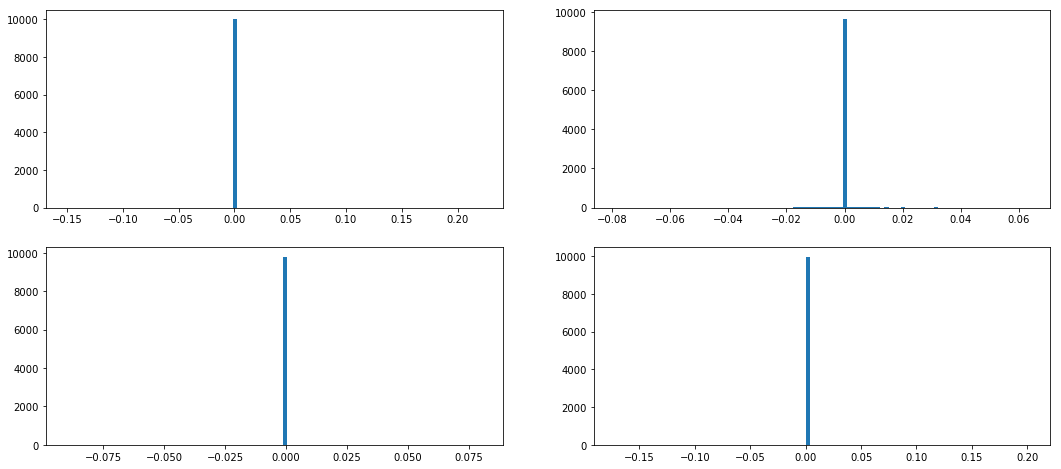

In [9]:
plt.figure(figsize=(18,8))
important_keggs = []
thresh = 0.00
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.hist(LR.coef_[i,:], bins=100)
    important_keggs.append(np.where(LR.coef_[i,:] > thresh)[0])

As we we can from the histograms, most of the weights for the KEGGs are 0 and hence lasso is indeed finding sparse solutions. 

We only consider weights that are strictly positive since the interperation of a postive weight is an increase in the log-odds of the cohort with increase in the abundance of the corresponding KEGG. 

Since we have 4 models, we take the *unioin* of the important KEGGs and treat this collection of KEGGs as the important KEGGs in discriminating between different cohorts. 

In [10]:
discriminating_keggs = np.array(list(set([kegg for keggs in important_keggs for kegg in keggs])))

print("Number of important KEGGs", len(discriminating_keggs))

Number of important KEGGs 342


The number of important KEGGs is significantly less than the original ~10K KEGGs we started out with. We next visualize the cluster heatmap for only these KEGGs

In [11]:
df_subset = df.iloc[discriminating_keggs,:]

total_abund = np.sum(df_subset.iloc[:,2:])

df_subset_normalized = df_subset.copy()
df_subset_normalized.iloc[:,2:] = df_subset_normalized.iloc[:,2:]/total_abund

np.min(df_subset_normalized.iloc[:,2:].values[df_subset_normalized.iloc[:,2:].values>0])

3.4515491884387597e-06

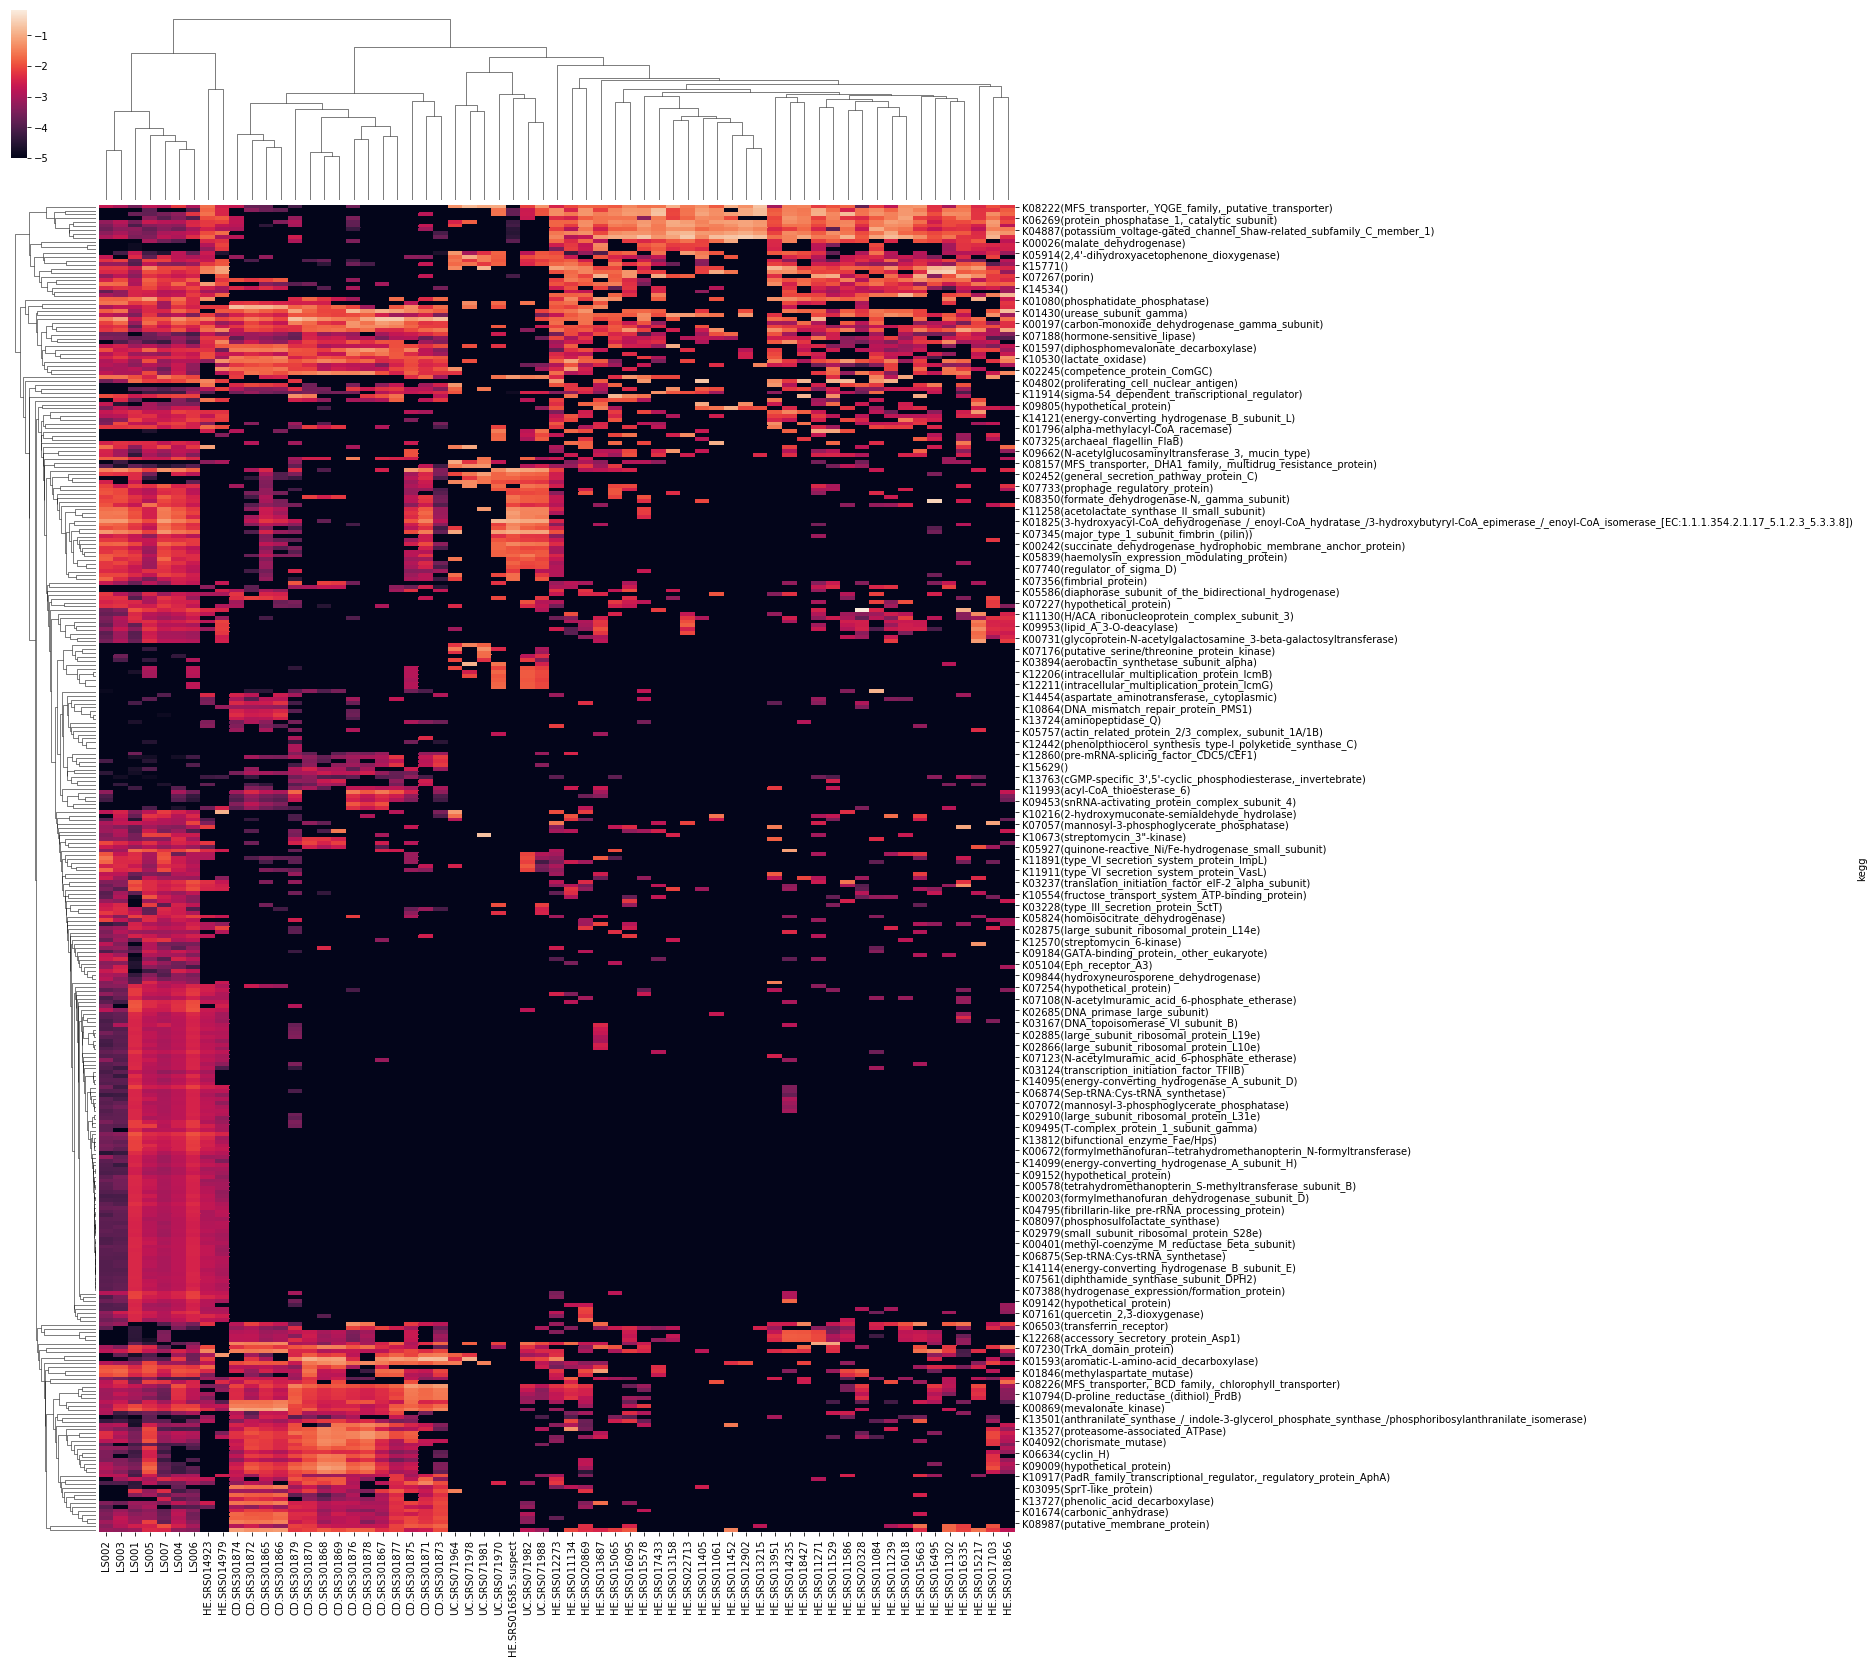

In [12]:
sns.clustermap(np.log10(1e-5+df_subset_normalized.iloc[:,2:]),
               figsize=(18, 28));

As we can see from above, reducing the number of KEGGs to the KEGGs that Lasso has found has significantly improved the cluseting. 

However, there are still an enromous number of KEGGs to consider and the clustering algorithm still fails on two HE subjects in the far left by the LS cohorts. 

# Part 2: Pairwise Logistic Regression

We next prepare the data so that they are pairwise comparisons of each sample and apply lass logistic regression to find the most important KEGGs that discriminate that either the samples are in the same cohort or not. We again use cross validation to select the penalty term. We select the important KEGGs as those that have a positive weight. 

The interpertation here is that a positive weight suggests that increasing this KEGG from one subject compared to another  (since we are doing pairwise comparisons) increases the log-odds of the KEGG determining of the the sample ratio are *not* in the same cohort. 


In this caes the data matrix has 1953 rows and 10K columns whereas before there were only 63 rows. We posit that the solution set we obtain here will be more sparse. 

In [13]:
def pairwise_diffs(np_arr):
    pairwise_indexes = list(itertools.combinations(list(range(np_arr.shape[0])), 2))    
    np_diffs = np.array([np.abs(np_arr[i,:] - np_arr[j,:]) for i, j in pairwise_indexes])
    return np_diffs

def get_sparse_set(input_arr, target_arr, laplace_scale):
    X_diffs = pairwise_diffs(np.log10(input_arr + laplace_scale))

    y_diffs = pairwise_diffs(target_arr[:, np.newaxis]).squeeze()
    y_diffs[y_diffs != 0] = 1
    
    LR = LogisticRegressionCV(Cs = np.logspace(-4, 2, 25), penalty="l1",
                              n_jobs=-2, solver = "liblinear")

    LR.fit(X_diffs, y_diffs)
    
    return LR

In [14]:
%%time

LR_all = get_sparse_set(X, y, laplace_scale)


CPU times: user 1.94 s, sys: 685 ms, total: 2.62 s
Wall time: 21.1 s


In [15]:
LR_all.C_

array([ 0.00562341])

In [16]:
LR_all.coef_.squeeze().shape

(10012,)

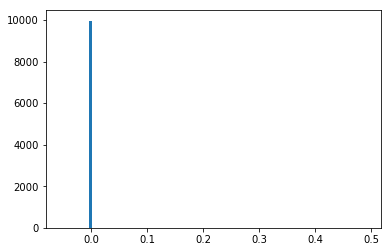

In [17]:
plt.hist(LR_all.coef_.squeeze(), bins=100);

In [18]:
thresh = 0
print(len(np.where(LR_all.coef_ > thresh)[1]))

10


We notice that the number of important KEGGs has been *significantly* reduced in this case; that is, we have a much sparser solution set.  

We next visualize these KEGGs with the clustered heatmap. 

In [19]:
discriminating_keggs = np.where(LR_all.coef_ > thresh)[1]

df_subset = df.iloc[discriminating_keggs,:]

total_abund = np.sum(df_subset.iloc[:,2:])

df_subset_normalized = df_subset.copy()
df_subset_normalized.iloc[:,2:] = df_subset_normalized.iloc[:,2:]/total_abund

np.min(df_subset_normalized.iloc[:,2:].values[df_subset_normalized.iloc[:,2:].values>0])

0.00030521466651673497

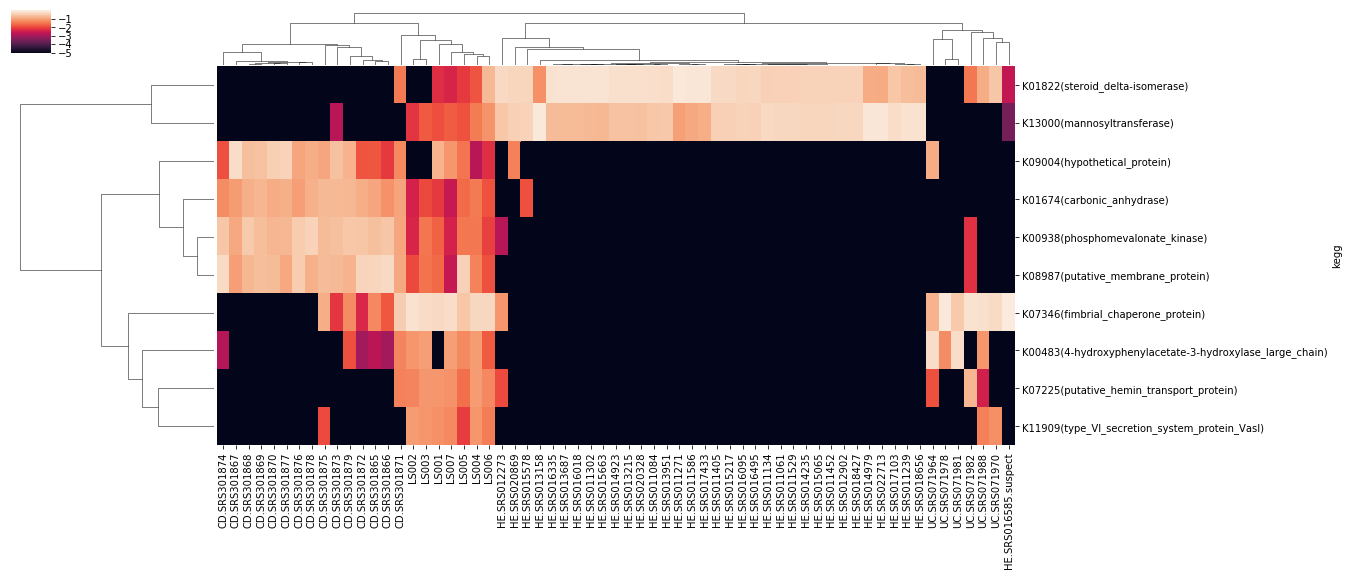

In [20]:
sns.clustermap(np.log10(1e-5+df_subset_normalized.iloc[:,2:]),
               figsize=(18, 8));

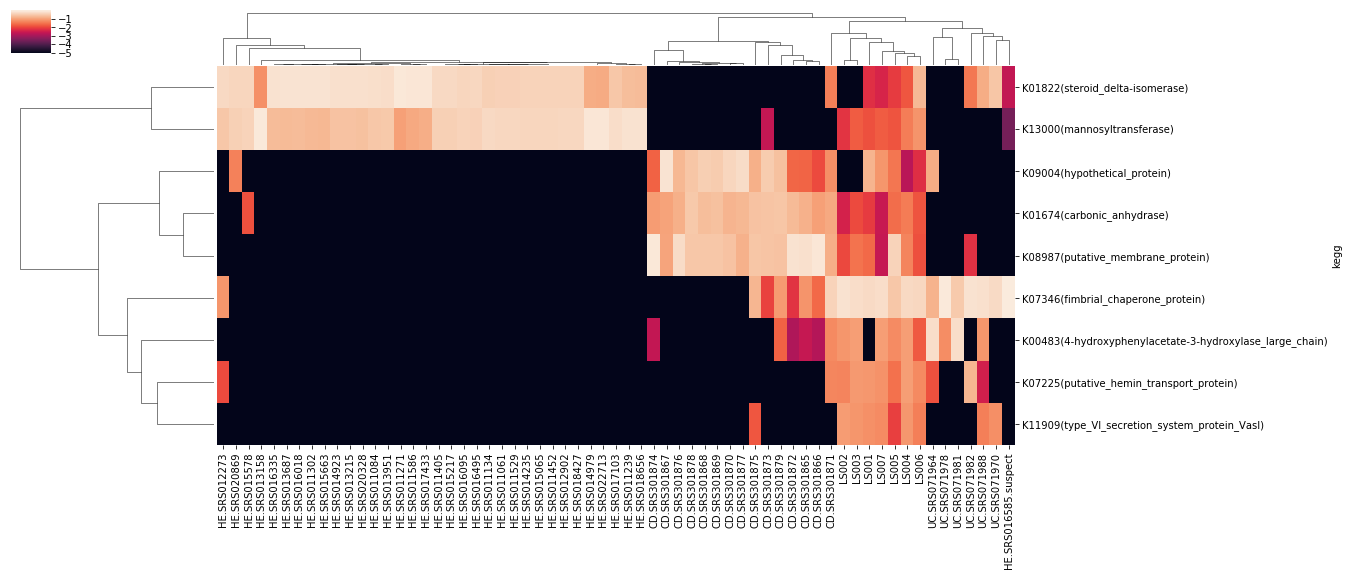

In [20]:
sns.clustermap(np.log10(1e-5+df_subset_normalized.iloc[:,2:]),
               figsize=(18, 8));

We note that the clustering has now significanlty improved from before, and that we have a significantly sparser set of KEGGs to work with 

# Part 2 addendum a: avoiding leakage 

The astute observer may have noticed that our pairwise comparison method may potentially be suffering from data leakage and hence yielding to unreliable estimates of the weight pentaly term.

Here we take etra care in performing a "leave one subject from each cohort out scheme" and estimate the distribution of sparsity for the different sets. 

In [21]:
HE_indx = list(np.where(y==0)[0])
LS_indx = list(np.where(y==1)[0])
CD_indx = list(np.where(y==2)[0])
UC_indx = list(np.where(y==3)[0])

In [22]:
from itertools import cycle

In [23]:
zip_list = zip(HE_indx, cycle(LS_indx), cycle(CD_indx), cycle(UC_indx))

For each subject from each cohort left out, we print out the subject indexes that have been left out. So 4 total subjects are left out in each run. We iteratore through all the subjects howevever we do not consider every possible combinatino.

We also print the number of KEGGs found and keep track of the KEGGs found for each set of subjects left out. 

In [24]:
%%time
collection_of_keggs = []
for excluse_indx in zip_list:
    print(excluse_indx)
    X_LOO= np.delete(X, excluse_indx, axis = 0)
    y_LOO = np.delete(y, excluse_indx, axis = 0)
    LR_loo = get_sparse_set(X_LOO, y_LOO, laplace_scale)
    print(len(np.where(LR_loo.coef_ > 0)[1]))
    collection_of_keggs.append(np.where(LR_loo.coef_ > 0)[1])

(28, 0, 7, 22)
7
(29, 1, 8, 23)
12
(30, 2, 9, 24)
12
(31, 3, 10, 25)
8
(32, 4, 11, 26)
5
(33, 5, 12, 27)
10
(34, 6, 13, 22)
8
(35, 0, 14, 23)
17
(36, 1, 15, 24)
8
(37, 2, 16, 25)
8
(38, 3, 17, 26)
6
(39, 4, 18, 27)
9
(40, 5, 19, 22)
8
(41, 6, 20, 23)
6
(42, 0, 21, 24)
10
(43, 1, 7, 25)
8
(44, 2, 8, 26)
10
(45, 3, 9, 27)
10
(46, 4, 10, 22)
8
(47, 5, 11, 23)
12
(48, 6, 12, 24)
20
(49, 0, 13, 25)
7
(50, 1, 14, 26)
5
(51, 2, 15, 27)
10
(52, 3, 16, 22)
9
(53, 4, 17, 23)
12
(54, 5, 18, 24)
12
(55, 6, 19, 25)
9
(56, 0, 20, 26)
19
(57, 1, 21, 27)
10
(58, 2, 7, 22)
10
(59, 3, 8, 23)
10
(60, 4, 9, 24)
18
(61, 5, 10, 25)
9
(62, 6, 11, 26)
21
CPU times: user 59.5 s, sys: 24.6 s, total: 1min 24s
Wall time: 10min 48s


We notice that for each differnt "fold", we have a different number of important KEGGs that have been discovered. We take the union of all these KEGGs to get the unique count of all important KEGGs from all folds

In [25]:
important_unleaked_keggs = np.array(list(set([kegg for keggs in collection_of_keggs for kegg in keggs])))

print("The number of KEGGs is", len(important_unleaked_keggs))

The number of KEGGs is 41


This is still significantly smaller and more sparase than the previous solution. 

We next investate how frequetly each of these KEGGs are classified as "important" in the different folds. That is, we ciount how often each KEGG is important in each fold. 

In [26]:
collection_of_keggs_list = [kegg for keggs in collection_of_keggs for kegg in keggs]

from collections import Counter

Counter(collection_of_keggs_list).most_common()

[(5962, 35),
 (8369, 35),
 (7730, 33),
 (1322, 31),
 (737, 28),
 (376, 26),
 (1446, 23),
 (4921, 23),
 (5979, 21),
 (5033, 17),
 (3257, 11),
 (9544, 7),
 (7849, 6),
 (7991, 6),
 (3148, 5),
 (1640, 5),
 (1779, 5),
 (1229, 5),
 (2182, 4),
 (8992, 4),
 (3275, 3),
 (4882, 3),
 (7064, 2),
 (5150, 2),
 (9171, 2),
 (8237, 2),
 (3274, 2),
 (2752, 2),
 (3571, 2),
 (6278, 2),
 (2139, 1),
 (6810, 1),
 (4215, 1),
 (215, 1),
 (2553, 1),
 (2557, 1),
 (4693, 1),
 (1916, 1),
 (674, 1),
 (2669, 1),
 (7108, 1)]

We note that out of the all the KEGGs, a smaller subset occur in multiple folds 

Let's look at KEGGs that occur a certain number of times:

In [27]:
important_keggs = [kegg for kegg, count in Counter(collection_of_keggs_list).most_common() if count >= 7]

In [28]:
df_subset = df.iloc[np.array(important_keggs),:]

total_abund = np.sum(df_subset.iloc[:,2:])

total_abund.min()

1.009614734432491e-05

In [29]:
df_subset_normalized = df_subset.copy()
df_subset_normalized.iloc[:,2:] = df_subset_normalized.iloc[:,2:]/(total_abund)

np.min(df_subset_normalized.iloc[:,2:].values[df_subset_normalized.iloc[:,2:].values>0])

0.00025916560761484429

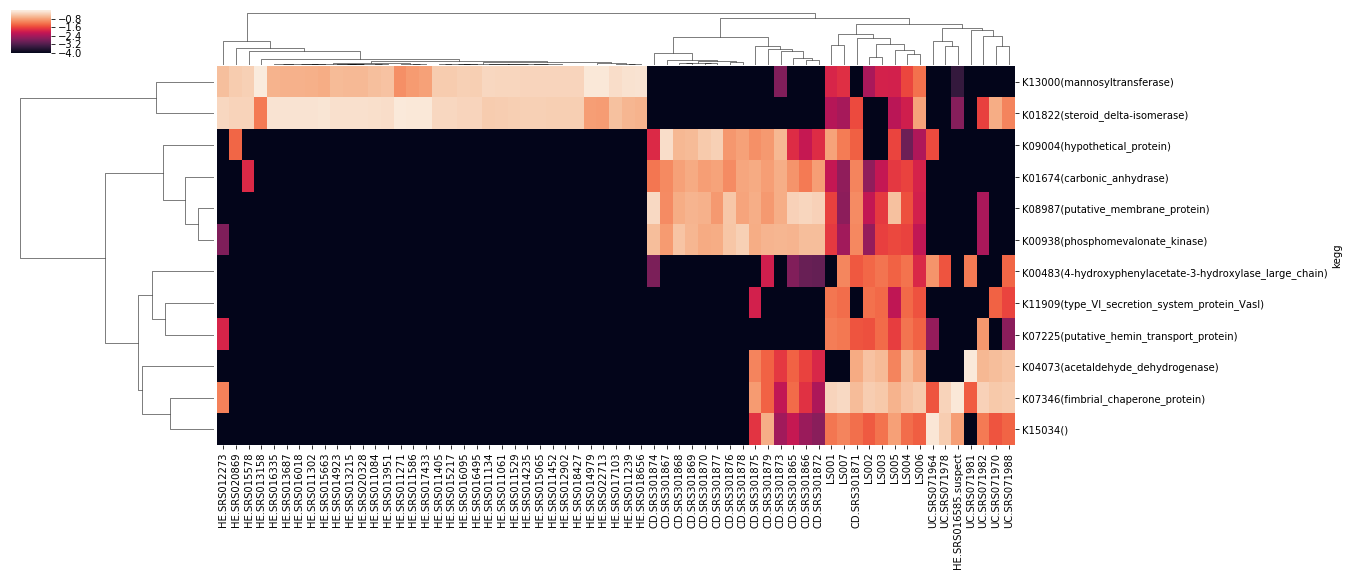

In [30]:
sns.clustermap(np.log10(1e-4+df_subset_normalized.iloc[:,2:]),
               figsize=(18, 8));

We agains see near perfect separation between the different cohorts but using significantly fewer KEGGs. 

There seeems to be some randomization because different runs will yield in slightly different KEGGs (below is the heatmap from a different run):

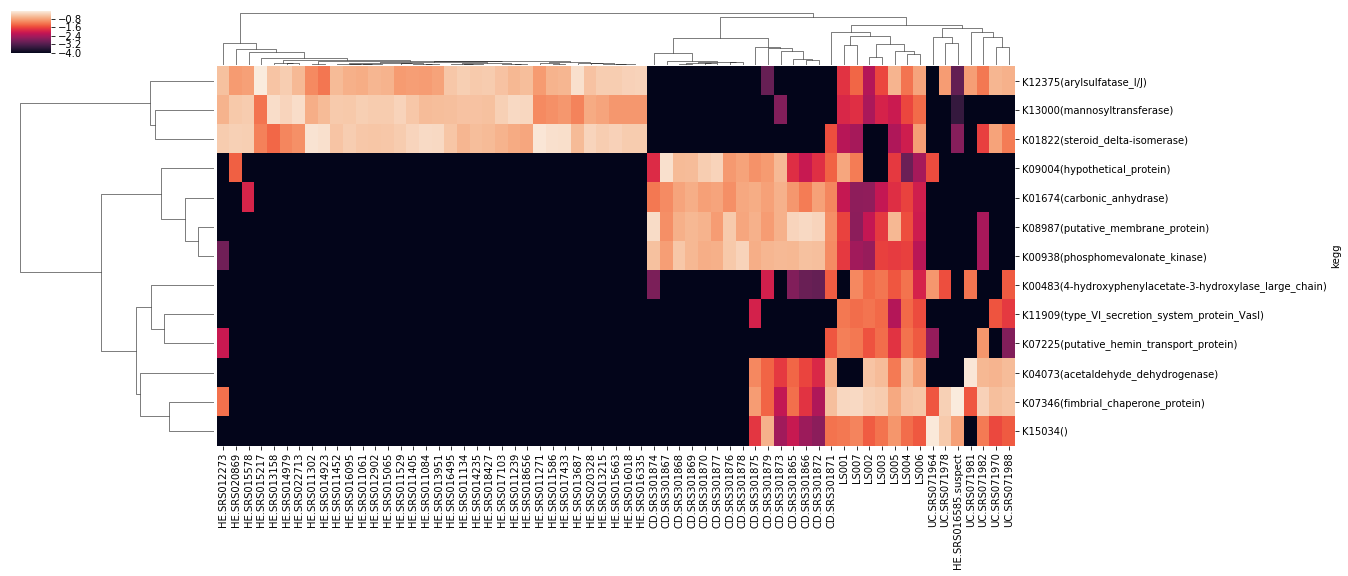

In [80]:
sns.clustermap(np.log10(1e-4+df_subset_normalized.iloc[:,2:]),
               figsize=(18, 8));

## Part 2 addendum b

To better understand the robustness of the KEGGs selected, we will estimate boostrapped probabilities for the KEGGs found. That is, we take boostrapped samples with replacement from the subjects and compute the important samples over many runs and count the frequency at which a KEGG is deemed important. 

We will use scikit-learn BaggingClassifier for bootstrapped estimations - this recquires us to define our own Pairwise logistic regression which we do below. 

In [42]:
from sklearn.base import BaseEstimator, ClassifierMixin
class PairwiseLR(BaseEstimator, ClassifierMixin):  
    def __init__(self, laplace_scale, **kwargs):
        self.laplace_scale = laplace_scale
        self.LR = LogisticRegressionCV(Cs = np.logspace(-4, -2, 10), penalty="l1",
                                       n_jobs=1, solver = "liblinear")
    
    def _pairwise_diffs(self, np_arr):
        pairwise_indexes = list(itertools.combinations(list(range(np_arr.shape[0])), 2))    
        np_diffs = np.array([np.abs(np_arr[i,:] - np_arr[j,:]) for i, j in pairwise_indexes])
        return np_diffs

    def fit(self, X, y):
        X_diffs = self._pairwise_diffs(np.log10(X + self.laplace_scale))

        y_diffs = self._pairwise_diffs(y[:, np.newaxis]).squeeze()
        y_diffs[y_diffs != 0] = 1        
        
        
        self.LR.fit(X_diffs, y_diffs)
        
        return self

    def predict(self, X, y=None):
        X_diffs = self._pairwise_diffs(np.log10(X + self.laplace_scale))
        return self.LR.predict(X_diffs)


In [43]:
from sklearn.ensemble import BaggingClassifier

We run 1000 bootstrapped estimators. 

In [114]:
clf = PairwiseLR(laplace_scale)

bg = BaggingClassifier(clf, 
                       bootstrap = True,
                       n_estimators=1000, 
                       n_jobs=-2, 
                       max_samples = 1.0)

In [115]:
%%time
bg.fit(X, y)

CPU times: user 8.65 s, sys: 40.2 s, total: 48.8 s
Wall time: 24min 32s


BaggingClassifier(base_estimator=PairwiseLR(laplace_scale=1e-09),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=1000, n_jobs=-2, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

Below we interrogate just one of the bootstrapped estimators:

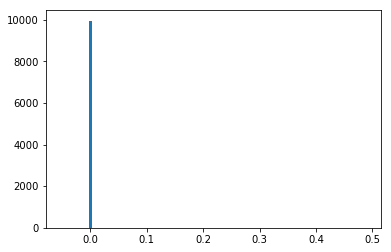

In [116]:
plt.hist(bg.estimators_[625].LR.coef_.squeeze(), bins=100);

In [117]:
len(np.where(bg.estimators_[625].LR.coef_.squeeze() >0)[0])

16

Lets now go through each estimator and count the number of times the KEGG appears as important in each bootstrapped estimate:

In [118]:
collection_of_keggs = []
for estimator in bg.estimators_:
    collection_of_keggs.append(np.where(estimator.LR.coef_.squeeze() >0)[0])

In [119]:
collection_of_keggs_list = [kegg for keggs in collection_of_keggs for kegg in keggs]

from collections import Counter

Counter(collection_of_keggs_list).most_common()

[(8369, 981),
 (5962, 837),
 (1322, 605),
 (7730, 567),
 (737, 511),
 (1779, 373),
 (7991, 360),
 (376, 359),
 (4921, 350),
 (1446, 329),
 (5979, 253),
 (5033, 232),
 (674, 229),
 (9544, 207),
 (3257, 196),
 (3275, 188),
 (1640, 185),
 (4215, 178),
 (1229, 166),
 (2182, 150),
 (7849, 139),
 (8992, 139),
 (2139, 127),
 (6278, 124),
 (2669, 119),
 (1777, 115),
 (7877, 112),
 (6418, 109),
 (9171, 109),
 (3148, 107),
 (8897, 104),
 (7851, 100),
 (4693, 98),
 (676, 94),
 (1852, 92),
 (5038, 88),
 (7885, 82),
 (2553, 75),
 (3555, 74),
 (4383, 71),
 (2752, 69),
 (554, 69),
 (8237, 65),
 (3274, 65),
 (9492, 64),
 (8648, 62),
 (4882, 59),
 (2554, 59),
 (5150, 56),
 (1296, 55),
 (7465, 55),
 (424, 55),
 (304, 54),
 (1718, 54),
 (215, 53),
 (1775, 53),
 (3571, 50),
 (7108, 49),
 (6810, 48),
 (7064, 47),
 (8578, 46),
 (1918, 43),
 (3149, 43),
 (2469, 43),
 (1916, 42),
 (6897, 40),
 (7463, 38),
 (7875, 38),
 (2180, 37),
 (2556, 35),
 (51, 34),
 (2117, 34),
 (2001, 34),
 (4803, 34),
 (5147, 33),
 (2

We plot the estimated bootstrapped probabilities below (only for the top 30 KEGGs to avoid overplotting):

In [120]:
kegg_frequency_counts = Counter(collection_of_keggs_list).most_common()

important_kegg_probabilities = [(df.kegg[kegg_index], 100*kegg_counts/1000) for kegg_index, kegg_counts in kegg_frequency_counts]

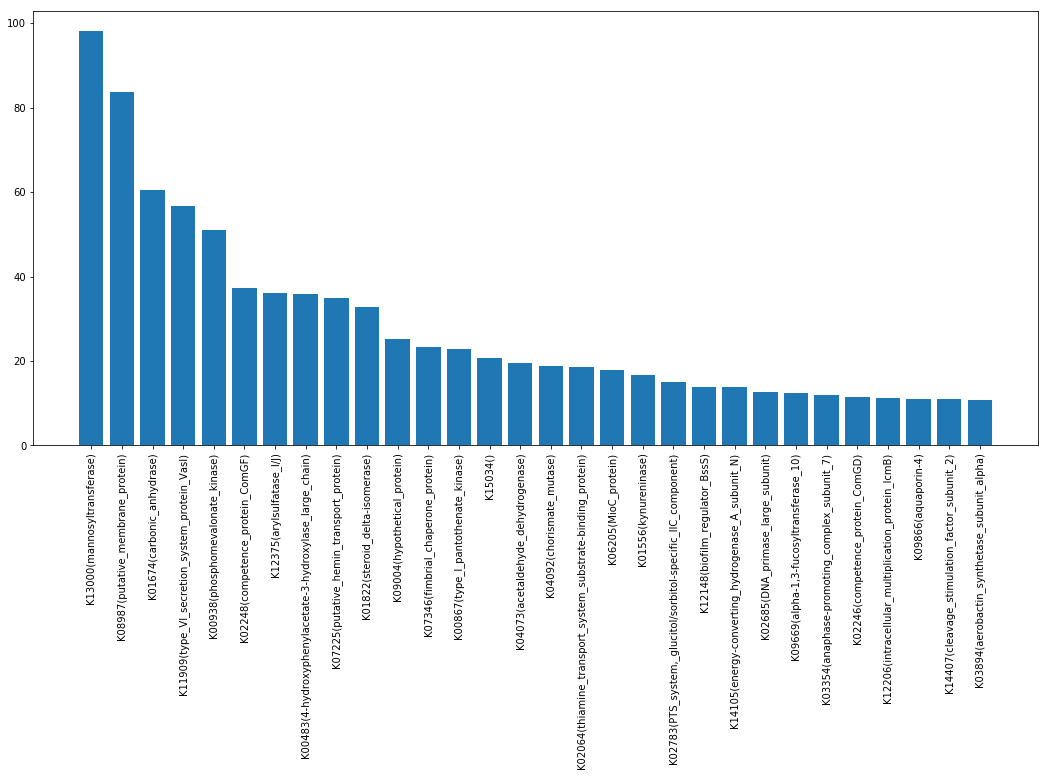

In [136]:
plt.figure(figsize=(18, 8))

probs = [prob for _, prob in important_kegg_probabilities]
kegg_names = [kegg_name for kegg_name, _ in important_kegg_probabilities]

plt.bar(np.arange(len(probs[:30])), probs[:30])
plt.xticks(np.arange(len(probs[:30])), kegg_names[:30], rotation=90);



Finally lets plot the KEGGs that were deemed as important for at leats 50% of the bootstrapped trials:

In [149]:
important_keggs = [kegg for kegg, count in Counter(collection_of_keggs_list).most_common() if count >= 500]

df_subset = df.iloc[np.array(important_keggs),:]

total_abund = np.sum(df_subset.iloc[:,2:])

total_abund.min()

0.0

In [150]:
df_subset_normalized = df_subset.copy()
df_subset_normalized.iloc[:,2:] = df_subset_normalized.iloc[:,2:]/(total_abund+.1)

np.min(df_subset_normalized.iloc[:,2:].values[df_subset_normalized.iloc[:,2:].values>0])

2.4714874368373447e-06

In [151]:
df_subset.shape

(5, 65)

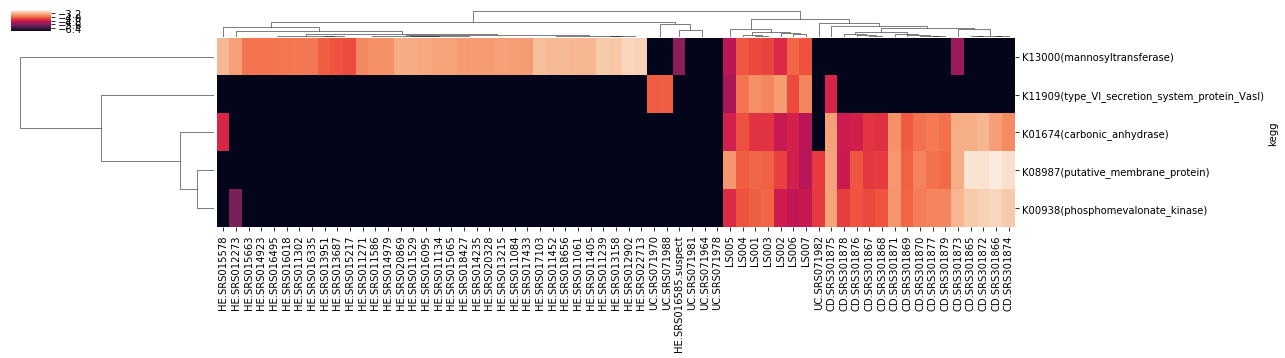

In [152]:
sns.clustermap(np.log10(1e-7+df_subset_normalized.iloc[:,2:]),
               figsize=(18, 4));

Lets also plot the heatmap for the top two highest probabilities:

In [153]:
important_keggs = [kegg for kegg, count in Counter(collection_of_keggs_list).most_common() if count >= 800]

df_subset = df.iloc[np.array(important_keggs),:]

total_abund = np.sum(df_subset.iloc[:,2:])

df_subset_normalized = df_subset.copy()
df_subset_normalized.iloc[:,2:] = df_subset_normalized.iloc[:,2:]/(total_abund+.1)

np.min(df_subset_normalized.iloc[:,2:].values[df_subset_normalized.iloc[:,2:].values>0])


3.8765222834631505e-06

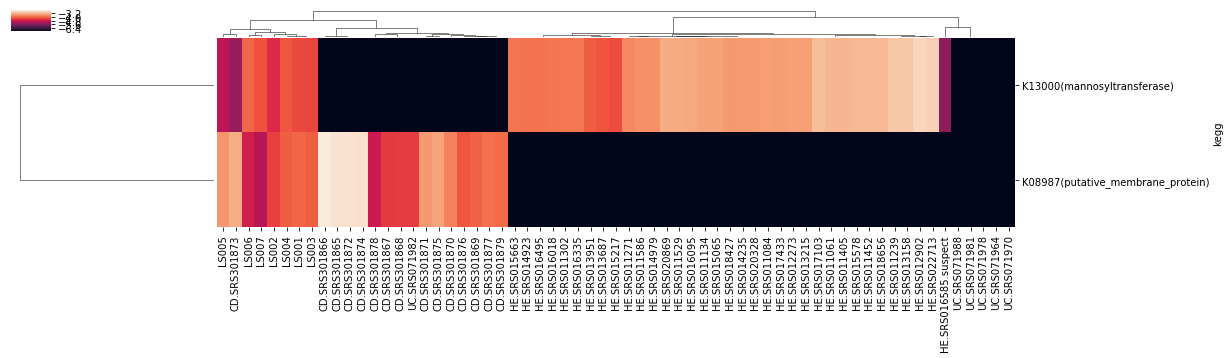

In [154]:
sns.clustermap(np.log10(1e-7+df_subset_normalized.iloc[:,2:]),
               figsize=(18, 4));

## Shuffled data

It is not clear what threshold probability to select when trying to figure out the important KEGGs. Below is an attemp at understanding what threshold to pick when we shuffle the data.

That is, we shuffle the targets and see how often a KEGG appears as important.

Since our data is small and the number of healthy cohorts is large in comparison, a random shuffle likely leads to significant overlap between the shuffled and unshuffled targets. We therefore discard any shuffled targets that has more than 25% overlap with the original (getting 0% overlap is impossible).

We run the shuffled experiment 10 times to get some idea for the distribution of randomness. 

In [45]:
from sklearn.utils import shuffle

In [62]:
%%time
bg_clfs = []
shuffle_amount = []
for _ in range(10):
    while True:
        y_shuffled = shuffle(y)
        percent_overlap = np.sum(y==y_shuffled)/len(y)
        if percent_overlap < .25:
            break
    
    


    bg = BaggingClassifier(clf, 
                           bootstrap = True,
                           n_estimators=1000, 
                           n_jobs=-2, 
                           max_samples = 1.0)
    bg.fit(X, y_shuffled)

    bg_clfs.append(bg)
    shuffle_amount.append(percent_overlap)

CPU times: user 56.8 s, sys: 5min 55s, total: 6min 52s
Wall time: 3h 47min 59s


Lets count the frequency of KEGGs being deemed as important for each of the randomly shuffled trials. Since these are all randomly shuffled, we expect the number of occurences to be low:

In [64]:
max_counts = []

for bg in bg_clfs:

    collection_of_keggs = []
    for estimator in bg.estimators_:
        collection_of_keggs.append(np.where(estimator.LR.coef_.squeeze() >0)[0])

    collection_of_keggs_list = [kegg for keggs in collection_of_keggs for kegg in keggs]

    print("-----")
    print(Counter(collection_of_keggs_list).most_common()[0:3])
    max_counts.append(Counter(collection_of_keggs_list).most_common()[0][1])
    
    

-----
[(7132, 517), (4854, 499), (4908, 496)]
-----
[(408, 438), (2761, 429), (2179, 416)]
-----
[(3934, 448), (6168, 410), (3238, 340)]
-----
[(7801, 510), (1663, 431), (1659, 421)]
-----
[(565, 437), (6936, 409), (6574, 374)]
-----
[(5963, 760), (3902, 745), (612, 449)]
-----
[(6900, 584), (2176, 374), (6259, 349)]
-----
[(4566, 646), (3370, 381), (8319, 375)]
-----
[(7763, 537), (3336, 382), (3135, 338)]
-----
[(5217, 543), (3168, 434), (3663, 395)]


We see that soem ome of the KEGGs can occasionally occur as much as 76% of the time. This is very high but recall that shuffled the data still has some overlap with the unshuffled data. 

This gives us some insight as to what threshold to select for important KEGG in the previous probability estimations above. So selecting a threshold of 50% may yield some false positives but it is less likeley to get false positives if we select the threshold at 80%.

Below lets take a look at what the heatmap looks like for randomly selecting some KEGGs.

In [80]:
important_keggs = [kegg for kegg, count in Counter(collection_of_keggs_list).most_common() if count >= 100]

df_subset = df.iloc[np.array(important_keggs),:]
#df_subset = df.iloc[np.array([8369, 5962]),:]
total_abund = np.sum(df_subset.iloc[:,2:])

total_abund.min()

3.4246090514561338e-05

In [81]:
df_subset_normalized = df_subset.copy()
df_subset_normalized.iloc[:,2:] = df_subset_normalized.iloc[:,2:]/(total_abund)

np.min(df_subset_normalized.iloc[:,2:].values[df_subset_normalized.iloc[:,2:].values>0])

8.1122676828125762e-06

In [82]:
df_subset.shape

(51, 65)

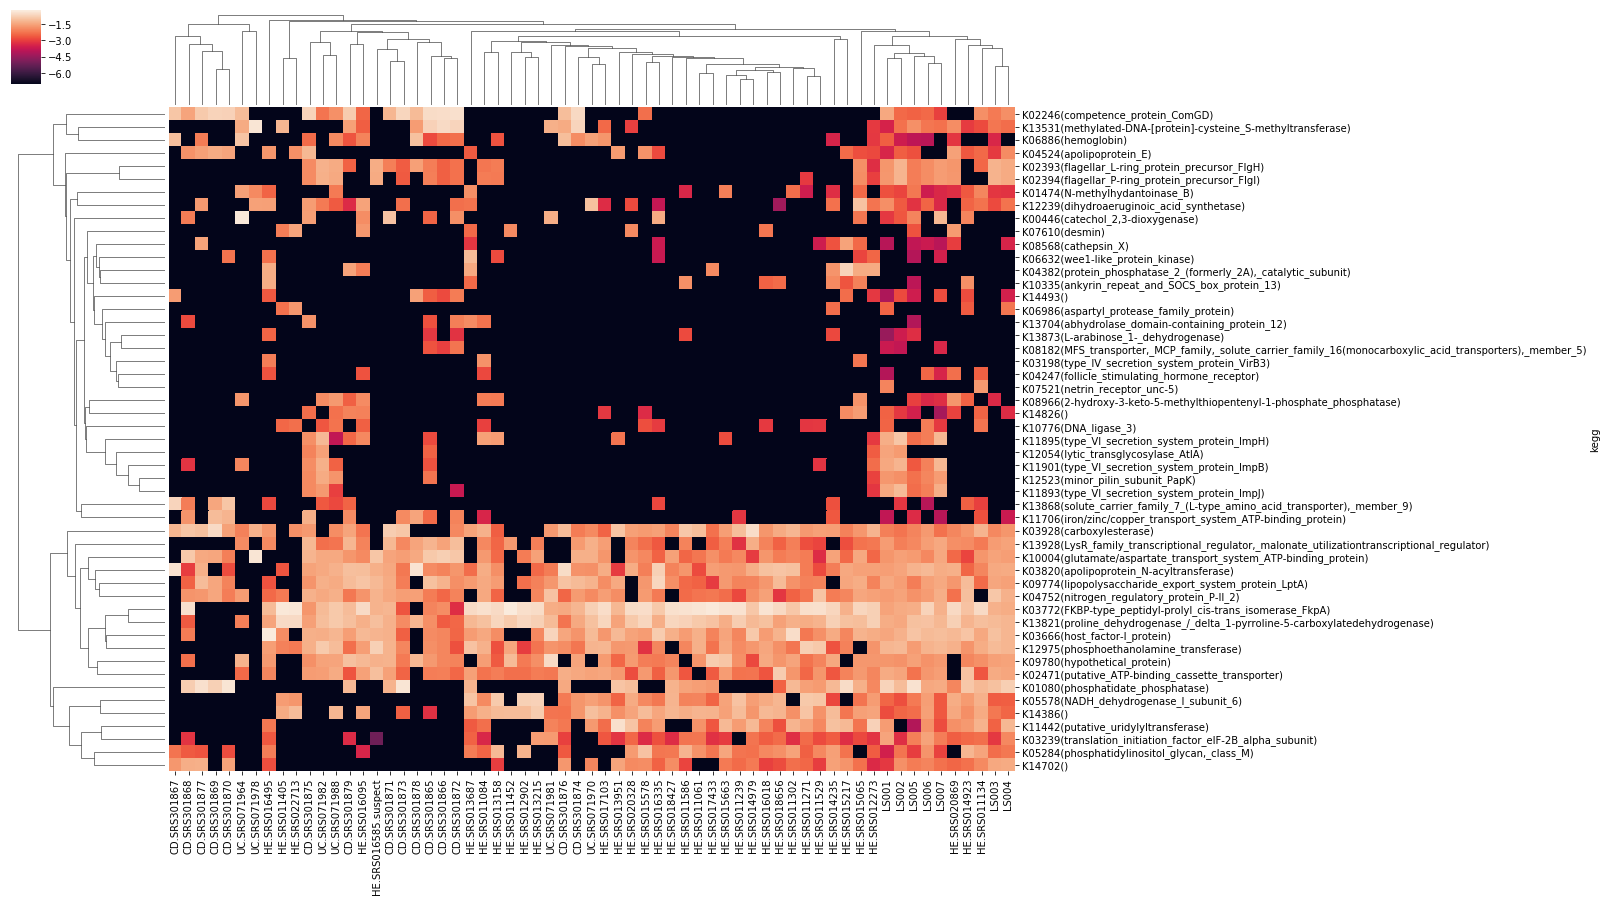

In [83]:
sns.clustermap(np.log10(1e-7+df_subset_normalized.iloc[:,2:]),
               figsize=(18, 14));

## LOO

In [88]:
%%time
collection_of_keggs = []
for HE_i in HE_indx:
    for LS_i in LS_indx:
        for CD_i in CD_indx:
            for UC_i in UC_indx:
                excluse_indx = (HE_i, LS_i, CD_i, UC_i)
                X_LOO= np.delete(X, excluse_indx, axis = 0)
                y_LOO = np.delete(y, excluse_indx, axis = 0)
                LR_loo = get_sparse_set(X_LOO, y_LOO, laplace_scale)
                collection_of_keggs.append(np.where(LR_loo.coef_ > 0)[1])

KeyboardInterrupt: 

## SVD on X_diff

Here we look at the difference between the singular values of the pairwise difference matrix and the original matrix. The conclusion that we draw is that pairwise differencing embeds additional information than the original matrix since the rank of the pairwise difference matrix is larger than the original matrix. 

In [70]:
X.shape

(63, 10012)

In [71]:
X_diff = pairwise_diffs(X)

In [72]:
X_diff.shape

(1953, 10012)

In [73]:
from scipy.linalg import svd

In [95]:
%%time
u, s, v = svd(np.dot(np.log10(X.T+laplace_scale), np.log10(X+laplace_scale)))
u_diff, s_diff, v_diff = svd(np.dot(X_diff.T, X_diff))

CPU times: user 48min 8s, sys: 2min 12s, total: 50min 20s
Wall time: 3min 2s


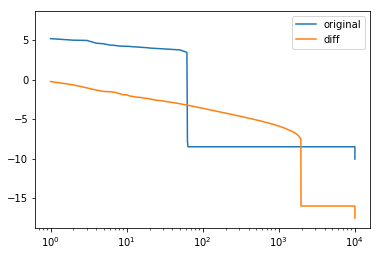

In [106]:
plt.semilogx(np.log10(s), label = "original")
plt.semilogx(np.log10(s_diff), label = 'diff');
plt.legend()

In [107]:
s[0]/s[X.shape[0]-1]

11517.357756016525

In [98]:
s_diff[0]/s_diff[X.shape[0]]

1757.6942359849238

In [108]:
s_diff[0]/s_diff[X_diff.shape[0]-1]

52886741.875732332

In [113]:
(s[0]/s[X.shape[0]])/(s_diff[0]/s_diff[X_diff.shape[0]])

0.20646007450852438

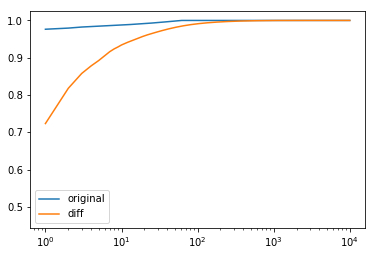

In [104]:
plt.semilogx(np.cumsum(s)/sum(s), label = "original")
plt.semilogx(np.cumsum(s_diff)/sum(s_diff), label = "diff")
plt.legend();

Above figure is the key result. The original data representation become "full rank" when the dimension reaches 63. Howver, the pairwise difference matrix reaches full rank when the dimension reaches 1953 (as we expect). Hence, the pairwise difference matrix has higher rank than the original matrix. 

In [156]:
np.sum(s_diff*np.log10(s_diff))

-1.0431054800502306

In [157]:
np.sum(s*np.log10(s))

241893049.13288304